# AI-Based Water Quality Monitoring System - Model Training


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use('seaborn-v0_8')

## 1. Load Data & Preprocessing

In [ ]:
try:
    df = pd.read_csv('Dataset/water_classified_fixed.csv')
    print("Dataset loaded. Original shape:", df.shape)
    print("Columns:", df.columns)
except FileNotFoundError:
    print("Error: Dataset not found. Check 'Dataset/water_classified_fixed.csv'.")

# Standardize column names and target labels
df.rename(columns={'pH': 'ph', 'TDS': 'Solids', 'Classification': 'Potability'}, inplace=True)
target_mapping = {'Safe': 1, 'Unsafe': 0}
df['Potability'] = df['Potability'].str.strip().map(target_mapping)
df = df.dropna(subset=['Potability'])
df['Potability'] = df['Potability'].astype(int)

# Remove extreme TDS outliers
tds_limit = 40000
initial_count = len(df)
df = df[df['Solids'] <= tds_limit]
cleaning_removed = initial_count - len(df)
print(f"\nData cleaning: removed {cleaning_removed} rows with TDS > {tds_limit}.")
print("Cleaned dataset shape:", df.shape)

features = ['ph', 'Solids']
target = 'Potability'
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)
df_imputed['Potability'] = df[target].values

X = df_imputed[features]
y = df_imputed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessed and split (features: ph, Solids).")
print("\n--- Preprocessed Data Preview (First 5 Rows) ---")
print(df_imputed.head())

Dataset loaded. Original Shape: (13145, 4)
Columns: Index(['Source', 'pH', 'TDS', 'Classification'], dtype='str')

Data Cleaning: Removed 19 rows with TDS > 40000.
Cleaned Dataset Shape: (13119, 4)
Data preprocessed and split (Features: pH, Solids).

--- Preprocessed Data Preview (First 5 Rows) ---
         ph      Solids  Potability
0  7.057230  366.800625           1
1  3.716080  385.375483           0
2  8.099124  272.094039           1
3  8.316766  236.123236           1
4  9.092223  258.967029           0


## 2. Exploratory Data Analysis (EDA)

### 2.1 Class Distribution

C:\Users\AMAN\AppData\Local\Temp\ipykernel_20684\1956721932.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Potability', data=df_imputed, palette='viridis')


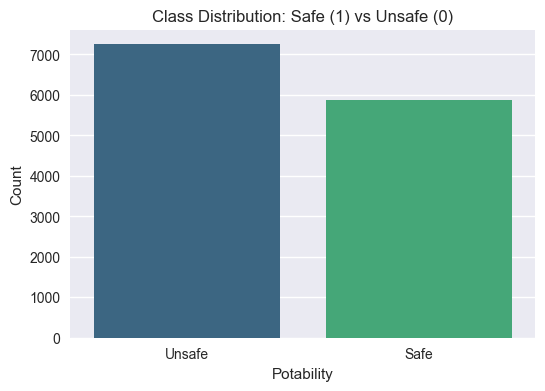

In [146]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Potability', data=df_imputed, palette='viridis')
plt.title('Class Distribution: Safe (1) vs Unsafe (0)')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Unsafe', 'Safe'])
plt.show()

### 2.2 Feature Distributions (Histograms)

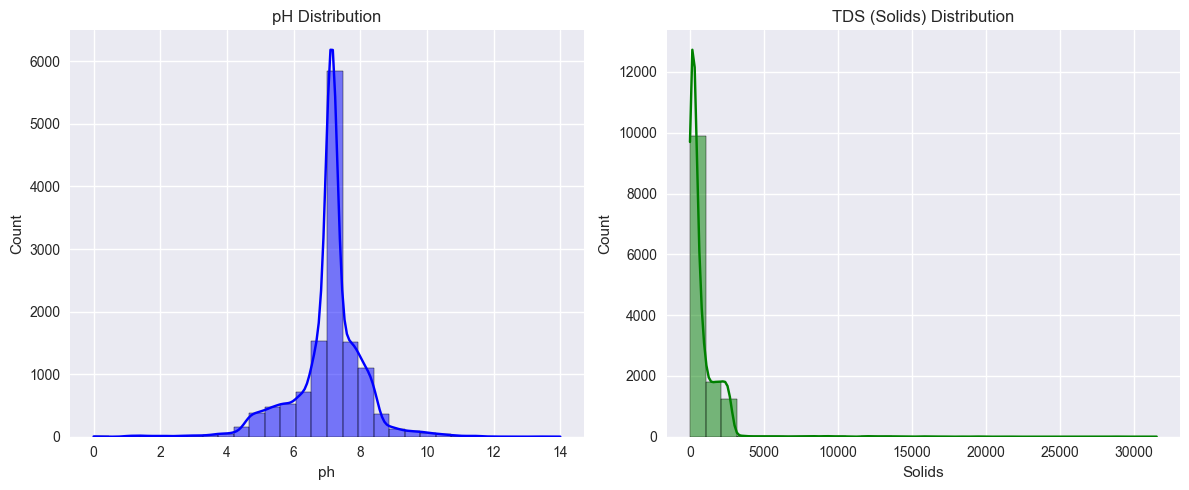

In [147]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_imputed['ph'], kde=True, color='blue', bins=30)
plt.title('pH Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df_imputed['Solids'], kde=True, color='green', bins=30)
plt.title('TDS (Solids) Distribution')

plt.tight_layout()
plt.show()

### 2.3 Scatter Plot: pH vs Solids (Sampled)

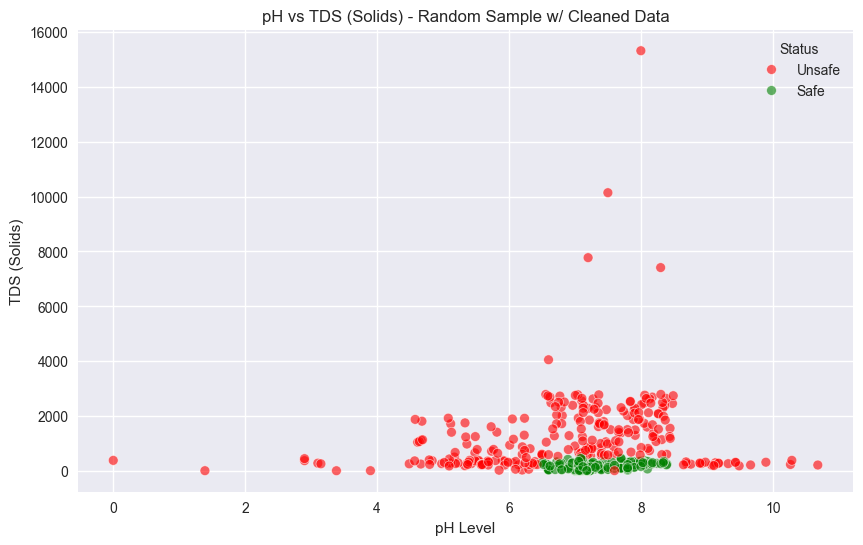

In [148]:
plt.figure(figsize=(10, 6))
# Sample 500 points to reduce clutter
df_plot = df_imputed.sample(n=min(500, len(df_imputed)), random_state=42).copy()
df_plot['Status'] = df_plot['Potability'].map({0: 'Unsafe', 1: 'Safe'})

sns.scatterplot(x='ph', y='Solids', hue='Status', data=df_plot, 
                palette={'Unsafe': 'red', 'Safe': 'green'}, 
                alpha=0.6, s=50)

plt.title('pH vs TDS (Solids) - Random Sample w/ Cleaned Data')
plt.xlabel('pH Level')
plt.ylabel('TDS (Solids)')
plt.show()

## 3. Model Training & Optimization

### 3.1 Random Forest Optimization (GridSearchCV)

In [ ]:
print("Starting hyperparameter tuning for Random Forest... (this may take a minute)")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Starting Hyperparameter Tuning for Random Forest... (This may take a minute)
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best Parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9996189387444031


### 3.2 SVM Training

In [150]:
print("Training SVM...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
print("SVM Trained.")

Training SVM...
SVM Trained.


## 4. Evaluation

In [ ]:
rf_pred = best_rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)

print(f"\nOptimized Random Forest Accuracy: {rf_acc:.4f}")
print(f"SVM Accuracy:                     {svm_acc:.4f}")

print("\n--- Optimized Random Forest Report ---")
print(classification_report(y_test, rf_pred))


Optimized Random Forest Accuracy: 0.9992
SVM Accuracy:                     0.9947

--- Optimized Random Forest Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1465
           1       1.00      1.00      1.00      1159

    accuracy                           1.00      2624
   macro avg       1.00      1.00      1.00      2624
weighted avg       1.00      1.00      1.00      2624



### 4.1 Confusion Matrix (Best RF Prediction)

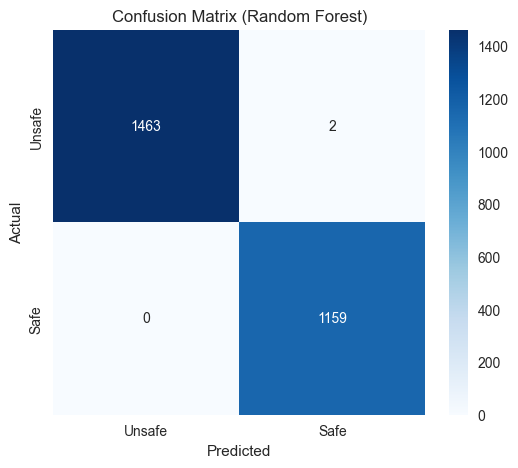

In [152]:
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unsafe', 'Safe'], 
            yticklabels=['Unsafe', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

### 4.2 Feature Importance (Best RF)

C:\Users\AMAN\AppData\Local\Temp\ipykernel_20684\3899972485.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[features[i] for i in indices], y=importances[indices], palette='viridis')


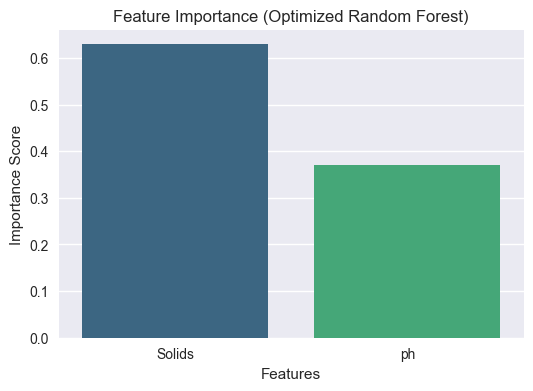

In [153]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
sns.barplot(x=[features[i] for i in indices], y=importances[indices], palette='viridis')
plt.title('Feature Importance (Optimized Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

## 5. Save Artifacts

In [ ]:
model_bundle = {
    'rf_model': best_rf_model,
    'svm_model': svm_model,
    'scaler': scaler,
    'imputer': imputer,
    'features': features
}

current_acc = max(rf_acc, svm_acc)
print(f"Best Model Accuracy: {current_acc:.2%}")

with open('water_model.pkl', 'wb') as f:
    pickle.dump(model_bundle, f)
print("Cleaned and optimized models saved to 'water_model.pkl'.")

Best Model Accuracy: 99.92%
Cleaned & Optimized models saved to 'water_model.pkl'.
